# Wild Cats Prediction

In [106]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [107]:
# Seed Everything to reproduce results for future runs
def seed_everything(seed=42):
    
    tf.random.set_seed(seed)
    
    np.random.seed(seed)
    
    random.seed(seed)

seed_everything()

In [108]:
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

## Placing data into a Dataframe

In [109]:
def convert_path_to_df(dataset):

    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + \
        list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

dataset = "."
image_df = convert_path_to_df(dataset)


In [110]:
image_df

Filepath            Label
0     test\AFRICAN LEOPARD\1.jpg  AFRICAN LEOPARD
1     test\AFRICAN LEOPARD\2.jpg  AFRICAN LEOPARD
2     test\AFRICAN LEOPARD\3.jpg  AFRICAN LEOPARD
3     test\AFRICAN LEOPARD\4.jpg  AFRICAN LEOPARD
4     test\AFRICAN LEOPARD\5.jpg  AFRICAN LEOPARD
...                          ...              ...
4873           valid\TIGER\1.jpg            TIGER
4874           valid\TIGER\2.jpg            TIGER
4875           valid\TIGER\3.jpg            TIGER
4876           valid\TIGER\4.jpg            TIGER
4877           valid\TIGER\5.jpg            TIGER

[4878 rows x 2 columns]

## Visualizing the images from the dataset

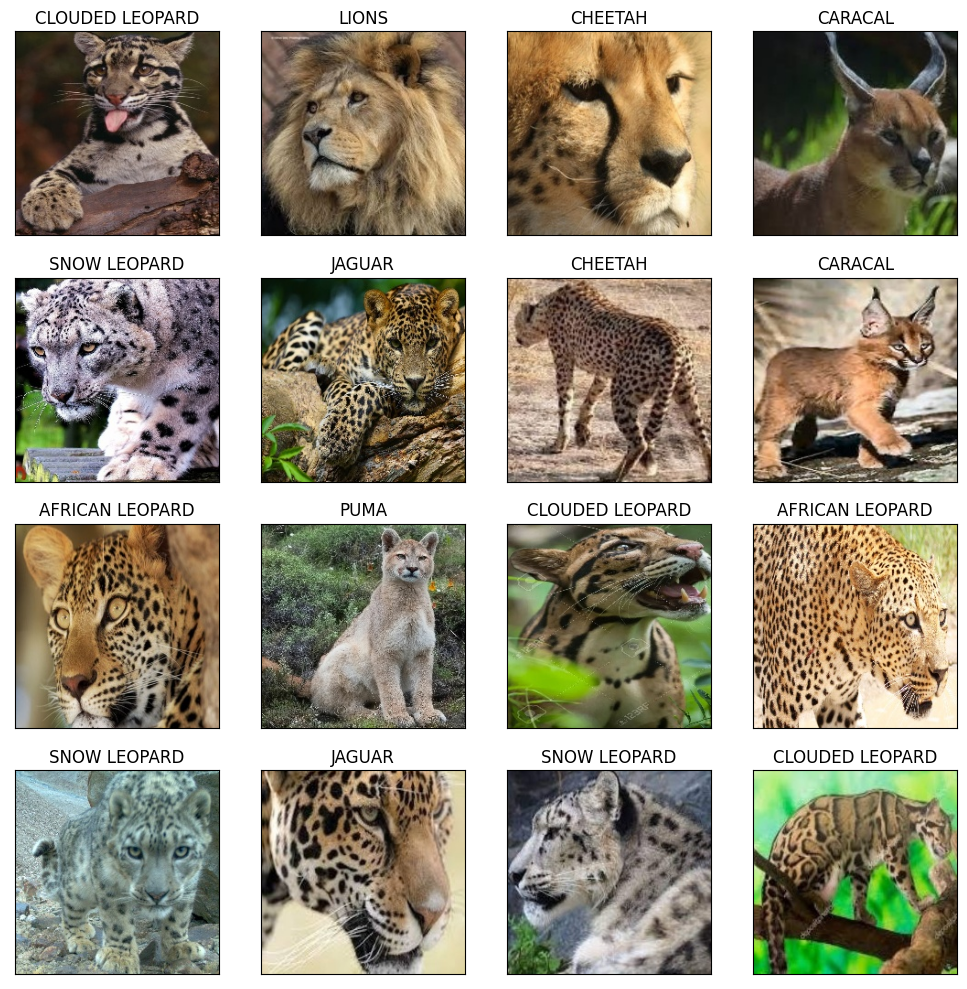

In [111]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])

plt.tight_layout()
plt.show()

## Computing Error Rate Analysis

In [112]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()


## Data Preprocessing

In [113]:
train = convert_path_to_df("train")
test = convert_path_to_df("test")
val = convert_path_to_df("valid")

In [114]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [115]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4678 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.


In [116]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## Training the model

In [117]:
# Load the pretained model
pretrained_model = tf.keras.applications.xception.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [118]:
# Create checkpoint callback
checkpoint_path = "wild_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [119]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [120]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/5
147/147 [==============================] - 39s 242ms/step - loss: 2.6673 - accuracy: 0.1513 - val_loss: 1.7937 - val_accuracy: 0.6400
Epoch 2/5
147/147 [==============================] - 32s 218ms/step - loss: 2.0701 - accuracy: 0.2762 - val_loss: 1.4823 - val_accuracy: 0.7200
Epoch 3/5
147/147 [==============================] - 33s 222ms/step - loss: 1.7648 - accuracy: 0.3985 - val_loss: 1.1847 - val_accuracy: 0.8000
Epoch 4/5
147/147 [==============================] - 33s 222ms/step - loss: 1.5649 - accuracy: 0.4795 - val_loss: 0.9490 - val_accuracy: 0.8400
Epoch 5/5
147/147 [==============================] - 34s 229ms/step - loss: 1.3314 - accuracy: 0.5686 - val_loss: 0.7526 - val_accuracy: 0.8600


## Model Evaluation

In [121]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.69427
Test Accuracy: 94.00%


## Visualizing loss curves

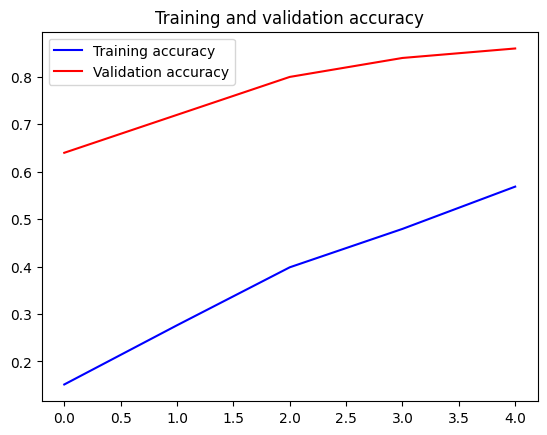

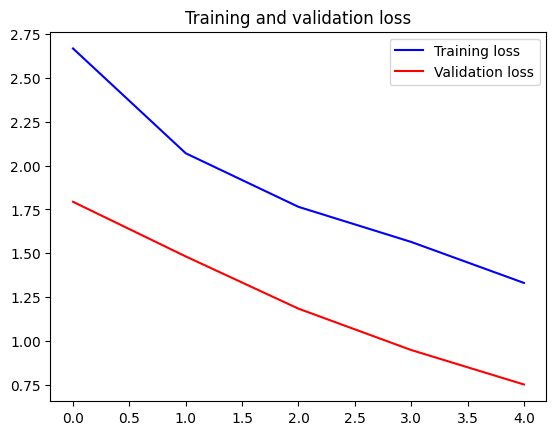

In [122]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Making predictions on the Test Data

In [123]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

4/4 [==============================] - 2s 197ms/step
The first 5 predictions: ['AFRICAN LEOPARD', 'AFRICAN LEOPARD', 'AFRICAN LEOPARD', 'AFRICAN LEOPARD', 'AFRICAN LEOPARD']


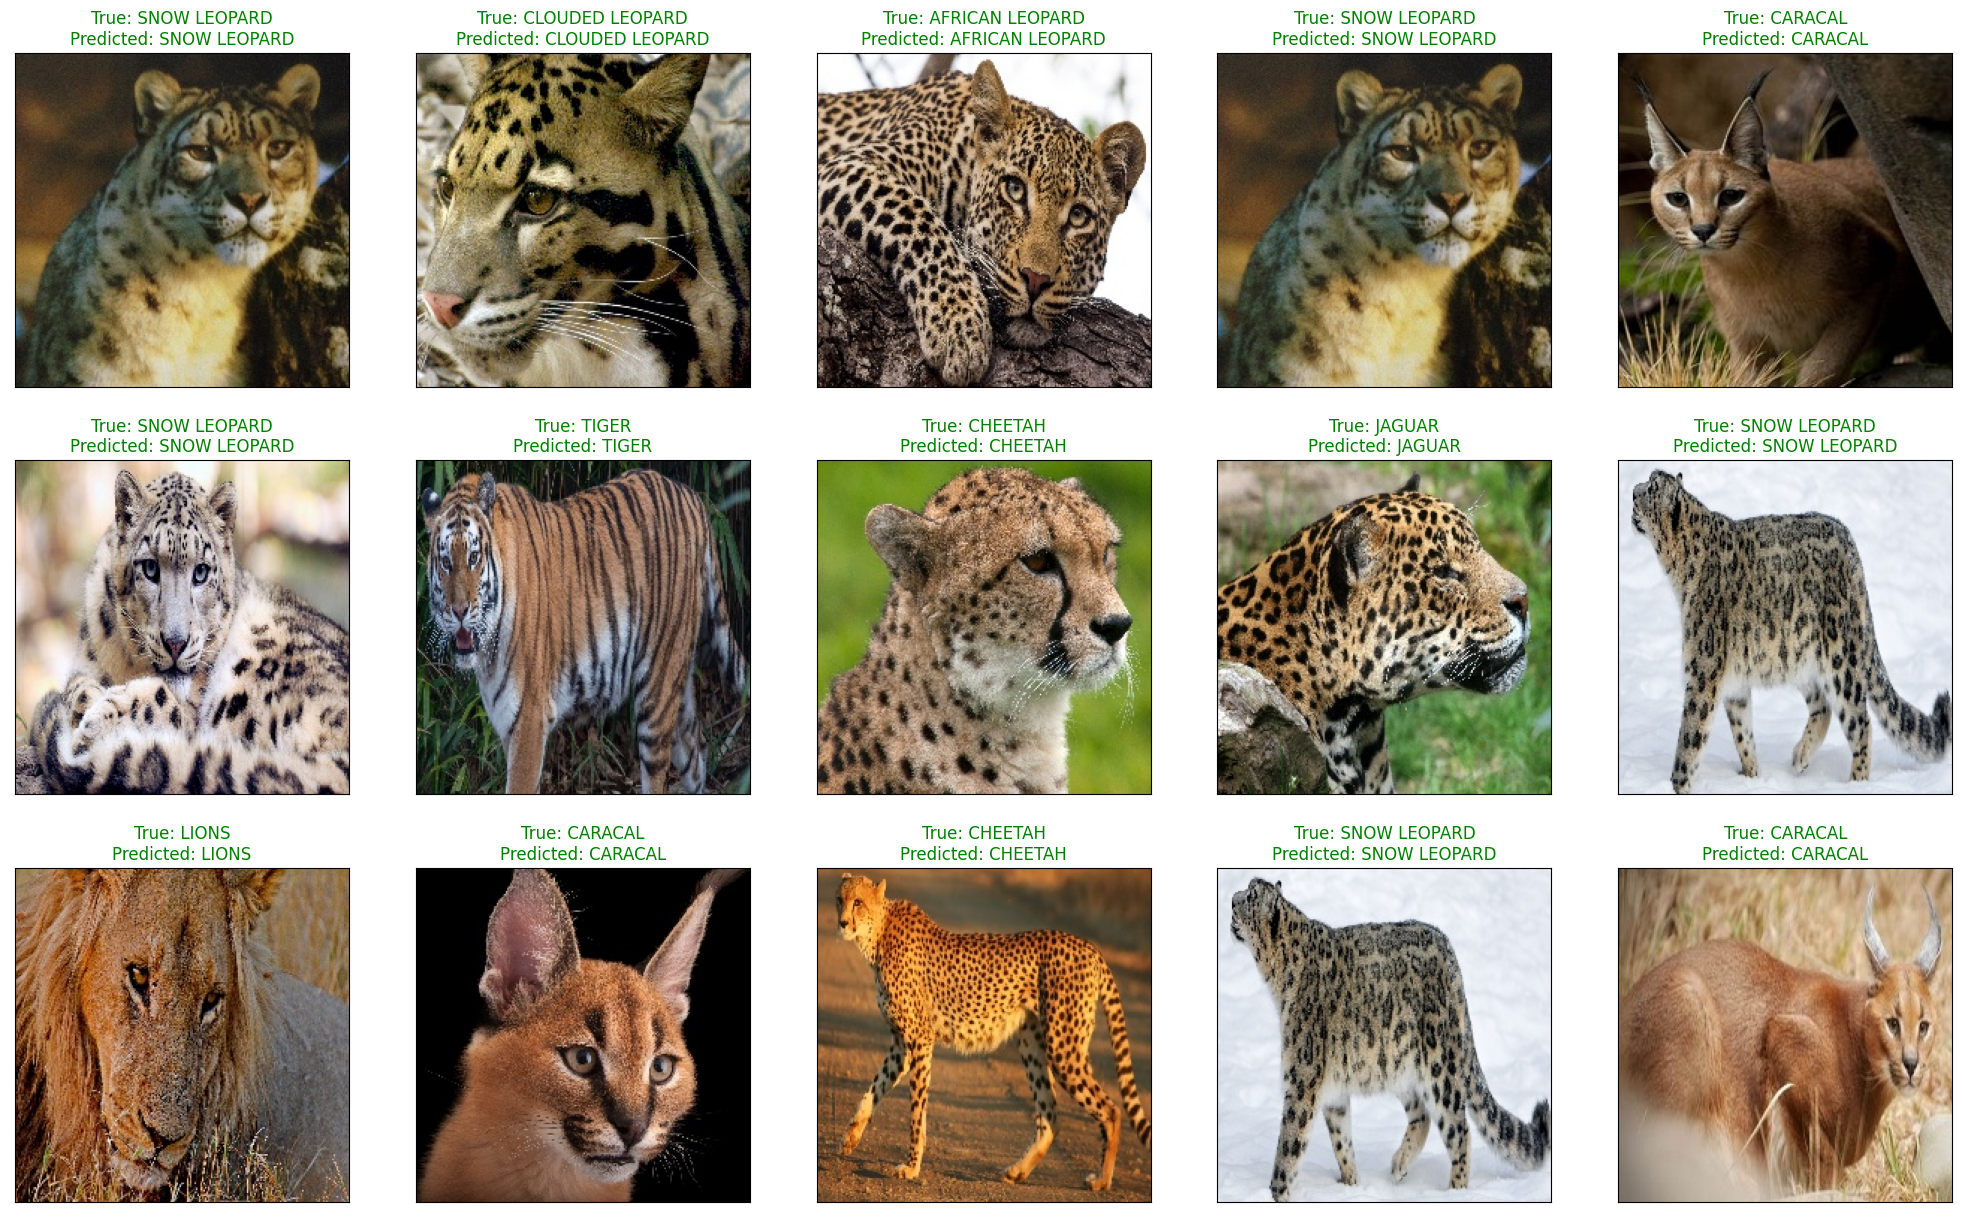

<Figure size 640x480 with 0 Axes>

In [125]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[random_index[i]]))
    if test.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [126]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

AFRICAN LEOPARD       1.00      1.00      1.00        10
        CARACAL       1.00      1.00      1.00        10
        CHEETAH       1.00      1.00      1.00        10
CLOUDED LEOPARD       0.75      0.60      0.67        10
         JAGUAR       0.83      1.00      0.91        10
          LIONS       1.00      1.00      1.00        10
         OCELOT       1.00      0.80      0.89        10
           PUMA       1.00      1.00      1.00        10
   SNOW LEOPARD       0.83      1.00      0.91        10
          TIGER       1.00      1.00      1.00        10

       accuracy                           0.94       100
      macro avg       0.94      0.94      0.94       100
   weighted avg       0.94      0.94      0.94       100



In [127]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision  recall  f1-score  support
AFRICAN LEOPARD   1.000000    1.00  1.000000    10.00
CARACAL           1.000000    1.00  1.000000    10.00
CHEETAH           1.000000    1.00  1.000000    10.00
CLOUDED LEOPARD   0.750000    0.60  0.666667    10.00
JAGUAR            0.833333    1.00  0.909091    10.00
LIONS             1.000000    1.00  1.000000    10.00
OCELOT            1.000000    0.80  0.888889    10.00
PUMA              1.000000    1.00  1.000000    10.00
SNOW LEOPARD      0.833333    1.00  0.909091    10.00
TIGER             1.000000    1.00  1.000000    10.00
accuracy          0.940000    0.94  0.940000     0.94
macro avg         0.941667    0.94  0.937374   100.00
weighted avg      0.941667    0.94  0.937374   100.00